In [29]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler


In [30]:
stock= pd.read_csv('stock.csv', parse_dates=True, index_col=0)

In [31]:
print(stock.columns)
print(stock.head())


Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
                Open      High       Low     Close        Volume
Date                                                            
2018-08-20  10698.76  10729.90  10663.44  10699.05           NaN
2018-08-17  10702.60  10757.01  10688.55  10690.96  2.096415e+09
2018-08-16  10663.57  10725.71  10606.26  10683.90  2.388831e+09
2018-08-15  10827.28  10827.28  10688.59  10716.75  2.481728e+09
2018-08-14  10797.95  10829.85  10755.53  10824.23  2.336858e+09


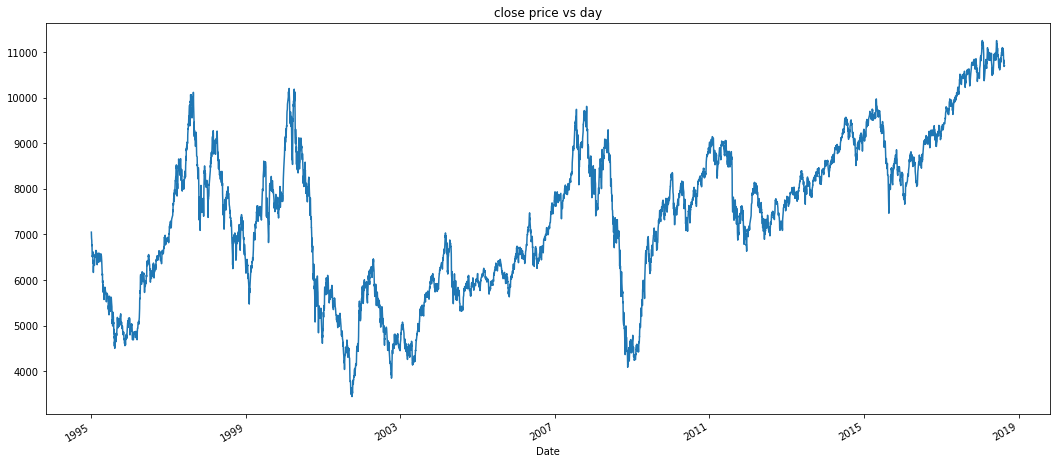

In [32]:
stock.loc[:]['Close'].plot(figsize=(18, 8), title='close price vs day')

                Open      High       Low     Close        Volume
Date                                                            
2018-08-20  10698.76  10729.90  10663.44  10699.05           NaN
2018-08-17  10702.60  10757.01  10688.55  10690.96  2.096415e+09
2018-08-16  10663.57  10725.71  10606.26  10683.90  2.388831e+09
2018-08-15  10827.28  10827.28  10688.59  10716.75  2.481728e+09
2018-08-14  10797.95  10829.85  10755.53  10824.23  2.336858e+09
               Open     High      Low    Close  Volume
Date                                                  
1995-01-05  7129.94  7144.70  7040.72  7051.49     NaN
1995-01-06  7086.88  7086.88  6884.61  6919.31     NaN
1995-01-07  6948.27  6948.27  6855.55  6915.40     NaN
1995-01-09  6948.73  6959.74  6869.08  6869.08     NaN
1995-01-10  6817.85  6838.95  6706.67  6756.88     NaN


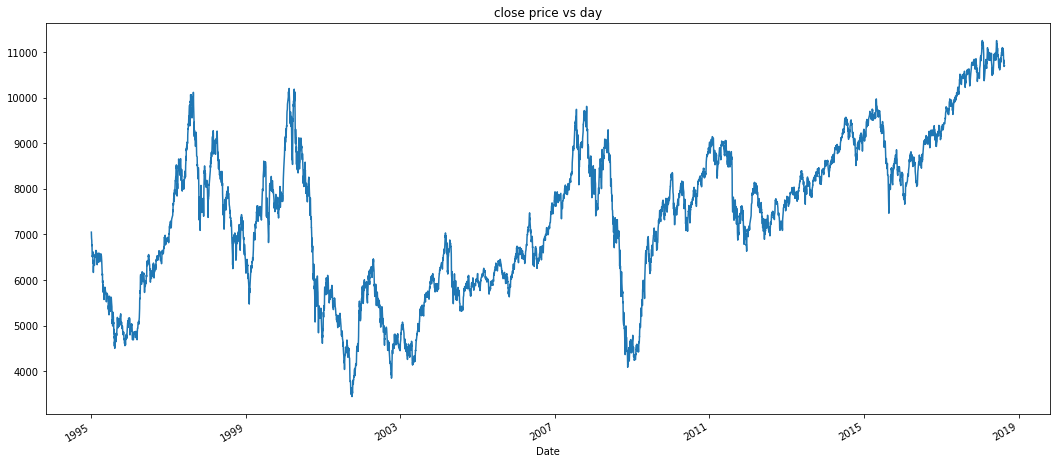

In [33]:
#stock = stock.set_index('Date')
print(stock.head())
stock = stock.sort_index(ascending=True, axis=0)
stock.loc[:]['Close'].plot(figsize=(18, 8), title='close price vs day')
print(stock.head())

In [34]:
print(stock)

                Open      High       Low     Close        Volume
Date                                                            
1995-01-05   7129.94   7144.70   7040.72   7051.49           NaN
1995-01-06   7086.88   7086.88   6884.61   6919.31           NaN
1995-01-07   6948.27   6948.27   6855.55   6915.40           NaN
1995-01-09   6948.73   6959.74   6869.08   6869.08           NaN
1995-01-10   6817.85   6838.95   6706.67   6756.88           NaN
1995-01-11   6736.11   6791.05   6720.07   6777.24           NaN
1995-01-12   6749.62   6749.62   6571.93   6609.50           NaN
1995-01-13   6673.26   6685.93   6582.05   6582.40           NaN
1995-01-14   6565.52   6565.52   6450.79   6511.30           NaN
1995-01-16   6556.98   6556.98   6473.06   6536.65           NaN
1995-01-17   6564.25   6574.77   6487.73   6515.79           NaN
1995-01-18   6558.74   6638.41   6546.99   6623.52           NaN
1995-01-19   6635.62   6672.63   6598.02   6598.02           NaN
1995-01-20   6572.85   65

In [35]:
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb)])
        Y.append(data[(i+lb)])
    return np.array(X),np.array(Y)

In [36]:
window_size = 1

In [37]:
#print(stock['Close'])
#print(stock['Close'].values)
scl = MinMaxScaler()
#Scale the data
closes = stock['Close'].values
closes = closes.reshape(closes.shape[0],1)
closes = scl.fit_transform(closes)
print(closes)
X,y = processData(closes, window_size)

[[0.46180342]
 [0.44487213]
 [0.44437129]
 ...
 [0.92708839]
 [0.92799272]
 [0.92902899]]


In [38]:
print(X[1])
print(y[1])

[[0.44487213]]
[0.44437129]


In [39]:
print(stock.loc[stock.index[89], 'Close'])
print(stock.loc[stock.index[90], 'Close'])
print(stock.loc[stock.index[91], 'Close'])

5771.81
5779.68
5699.14


In [40]:
print(len(stock))
print(len(X))
stock_split_index = len(X) - 90
print(stock_split_index)
X_train,X_test = X[:stock_split_index],X[stock_split_index:]
y_train,y_test = y[:stock_split_index],y[stock_split_index:]

5919
5917
5827


In [41]:
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])
print(X_train.shape[1])

5827
90
5827
90
1


In [42]:
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();

In [43]:
plot = PlotLearning()
#Build the model
model = Sequential()
model.add(LSTM(256,input_shape=(window_size,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting
#history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False,callbacks=[plot])
history = model.fit(X_train,y_train,epochs=120,validation_data=(X_test,y_test),shuffle=False)

Train on 5827 samples, validate on 90 samples
Epoch 1/120
5827/5827 [==============================] - 2s 426us/step - loss: 0.0288 - val_loss: 0.0012
Epoch 2/120
5827/5827 [==============================] - 1s 232us/step - loss: 0.0081 - val_loss: 2.7274e-04
Epoch 3/120
5827/5827 [==============================] - 1s 228us/step - loss: 0.0023 - val_loss: 1.0908e-04
Epoch 4/120
5827/5827 [==============================] - 1s 233us/step - loss: 5.0782e-04 - val_loss: 1.1859e-04
Epoch 5/120
5827/5827 [==============================] - 1s 231us/step - loss: 2.2169e-04 - val_loss: 1.1822e-04
Epoch 6/120
5827/5827 [==============================] - 1s 225us/step - loss: 1.9219e-04 - val_loss: 1.2153e-04
Epoch 7/120
5827/5827 [==============================] - 1s 237us/step - loss: 1.8892e-04 - val_loss: 1.2842e-04
Epoch 8/120
5827/5827 [==============================] - 1s 239us/step - loss: 1.8809e-04 - val_loss: 1.3731e-04
Epoch 9/120
5827/5827 [==============================] - 1s 246us/

5827/5827 [==============================] - 1s 238us/step - loss: 3.0920e-04 - val_loss: 1.0820e-04
Epoch 73/120
5827/5827 [==============================] - 1s 232us/step - loss: 3.0717e-04 - val_loss: 1.0822e-04
Epoch 74/120
5827/5827 [==============================] - 1s 236us/step - loss: 3.0606e-04 - val_loss: 1.0835e-04
Epoch 75/120
5827/5827 [==============================] - 2s 263us/step - loss: 3.0332e-04 - val_loss: 1.0838e-04
Epoch 76/120
5827/5827 [==============================] - 1s 250us/step - loss: 2.9895e-04 - val_loss: 1.0823e-04
Epoch 77/120
5827/5827 [==============================] - 1s 246us/step - loss: 2.9896e-04 - val_loss: 1.0810e-04
Epoch 78/120
5827/5827 [==============================] - 1s 236us/step - loss: 2.9963e-04 - val_loss: 1.0818e-04
Epoch 79/120
5827/5827 [==============================] - 1s 239us/step - loss: 2.9877e-04 - val_loss: 1.0826e-04
Epoch 80/120
5827/5827 [==============================] - 1s 236us/step - loss: 2.9793e-04 - val_loss

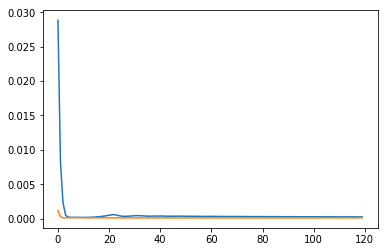

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

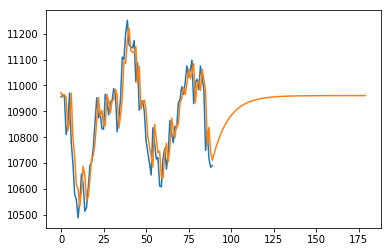

In [45]:
#Xt = model.predict(X_test)
#plt.plot(y_test.reshape(-1,1))
#plt.plot(Xt)

Xt = model.predict(X_test)

for i in range(90):
    newVal = model.predict(Xt[-1].reshape(1,1,1))
    Xt = np.append(Xt, newVal)

plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
#plt.plot(stock['Close'].values.reshape(-1,1))
plt.plot(scl.inverse_transform(Xt.reshape(-1, 1)))

In [46]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(window_size,1)))
model.add(LSTM(256,input_shape=(window_size,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting
#history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False,callbacks=[plot])
history = model.fit(X_train,y_train,epochs=120,validation_data=(X_test,y_test),shuffle=False)

Train on 5827 samples, validate on 90 samples
Epoch 1/120
5827/5827 [==============================] - 5s 943us/step - loss: 0.0140 - val_loss: 0.0043
Epoch 2/120
5827/5827 [==============================] - 4s 661us/step - loss: 0.0044 - val_loss: 1.1037e-04
Epoch 3/120
5827/5827 [==============================] - 4s 673us/step - loss: 4.6630e-04 - val_loss: 1.1307e-04
Epoch 4/120
5827/5827 [==============================] - 4s 686us/step - loss: 1.8662e-04 - val_loss: 1.1197e-04
Epoch 5/120
5827/5827 [==============================] - 4s 678us/step - loss: 2.0833e-04 - val_loss: 1.1068e-04
Epoch 6/120
5827/5827 [==============================] - 4s 669us/step - loss: 2.3072e-04 - val_loss: 1.1658e-04
Epoch 7/120
5827/5827 [==============================] - 4s 690us/step - loss: 2.3159e-04 - val_loss: 1.2081e-04
Epoch 8/120
5827/5827 [==============================] - 4s 696us/step - loss: 2.0339e-04 - val_loss: 1.2574e-04
Epoch 9/120
5827/5827 [==============================] - 4s 67

Epoch 73/120
5827/5827 [==============================] - 4s 660us/step - loss: 3.1178e-04 - val_loss: 2.0197e-04
Epoch 74/120
5827/5827 [==============================] - 4s 653us/step - loss: 3.2627e-04 - val_loss: 1.9816e-04
Epoch 75/120
5827/5827 [==============================] - 4s 677us/step - loss: 3.2129e-04 - val_loss: 2.0090e-04
Epoch 76/120
5827/5827 [==============================] - 4s 677us/step - loss: 3.2746e-04 - val_loss: 1.9490e-04
Epoch 77/120
5827/5827 [==============================] - 4s 656us/step - loss: 3.1758e-04 - val_loss: 1.9656e-04
Epoch 78/120
5827/5827 [==============================] - 4s 657us/step - loss: 3.2010e-04 - val_loss: 1.9097e-04
Epoch 79/120
5827/5827 [==============================] - 4s 675us/step - loss: 3.1182e-04 - val_loss: 1.9046e-04
Epoch 80/120
5827/5827 [==============================] - 4s 680us/step - loss: 3.0541e-04 - val_loss: 1.8694e-04
Epoch 81/120
5827/5827 [==============================] - 4s 664us/step - loss: 3.0102e-

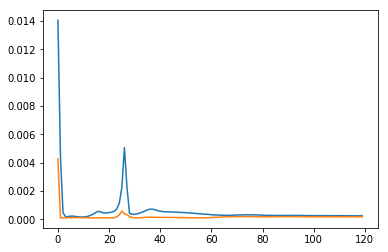

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

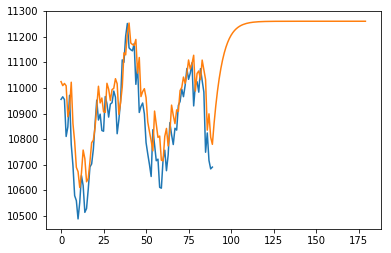

In [48]:
#Xt = model.predict(X_test)
#plt.plot(y_test.reshape(-1,1))
#plt.plot(Xt)

Xt = model.predict(X_test)

for i in range(90):
    newVal = model.predict(Xt.reshape(Xt.shape[0],1,1))
    Xt = np.append(Xt, newVal[-1])

plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
#plt.plot(stock['Close'].values.reshape(-1,1))
plt.plot(scl.inverse_transform(Xt.reshape(-1, 1)))

In [49]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(window_size,1)))
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(256,input_shape=(window_size,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting
#history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False,callbacks=[plot])
history = model.fit(X_train,y_train,epochs=120,validation_data=(X_test,y_test),shuffle=False)

Train on 5827 samples, validate on 90 samples
Epoch 1/120
5827/5827 [==============================] - 9s 2ms/step - loss: 0.0208 - val_loss: 0.0177
Epoch 2/120
5827/5827 [==============================] - 6s 1ms/step - loss: 0.0201 - val_loss: 0.0041
Epoch 3/120
5827/5827 [==============================] - 6s 1ms/step - loss: 0.0019 - val_loss: 1.3163e-04
Epoch 4/120
5827/5827 [==============================] - 6s 1ms/step - loss: 1.7498e-04 - val_loss: 1.0991e-04
Epoch 5/120
5827/5827 [==============================] - 6s 1ms/step - loss: 2.0451e-04 - val_loss: 1.0567e-04
Epoch 6/120
5827/5827 [==============================] - 6s 1ms/step - loss: 2.6593e-04 - val_loss: 1.1199e-04
Epoch 7/120
5827/5827 [==============================] - 6s 1ms/step - loss: 3.5624e-04 - val_loss: 1.0747e-04
Epoch 8/120
5827/5827 [==============================] - 6s 1ms/step - loss: 4.8010e-04 - val_loss: 1.0854e-04
Epoch 9/120
5827/5827 [==============================] - 6s 1ms/step - loss: 6.8911e-0

5827/5827 [==============================] - 6s 1ms/step - loss: 3.7494e-04 - val_loss: 2.7241e-04
Epoch 75/120
5827/5827 [==============================] - 6s 1ms/step - loss: 3.7660e-04 - val_loss: 2.5179e-04
Epoch 76/120
5827/5827 [==============================] - 6s 1ms/step - loss: 3.7496e-04 - val_loss: 2.4247e-04
Epoch 77/120
5827/5827 [==============================] - 6s 1ms/step - loss: 3.3115e-04 - val_loss: 2.6644e-04
Epoch 78/120
5827/5827 [==============================] - 7s 1ms/step - loss: 3.7150e-04 - val_loss: 2.4391e-04
Epoch 79/120
5827/5827 [==============================] - 6s 1ms/step - loss: 3.9095e-04 - val_loss: 2.5114e-04
Epoch 80/120
5827/5827 [==============================] - 6s 1ms/step - loss: 3.3170e-04 - val_loss: 2.7236e-04
Epoch 81/120
5827/5827 [==============================] - 6s 1ms/step - loss: 3.6590e-04 - val_loss: 2.8179e-04
Epoch 82/120
5827/5827 [==============================] - 6s 1ms/step - loss: 3.9559e-04 - val_loss: 2.2226e-04
Epoch

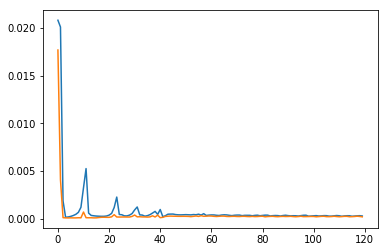

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

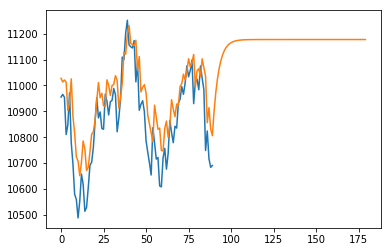

In [51]:
#Xt = model.predict(X_test)
#plt.plot(y_test.reshape(-1,1))
#plt.plot(Xt)

Xt = model.predict(X_test)

for i in range(90):
    newVal = model.predict(Xt.reshape(Xt.shape[0],1,1))
    Xt = np.append(Xt, newVal[-1])

plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
#plt.plot(stock['Close'].values.reshape(-1,1))
plt.plot(scl.inverse_transform(Xt.reshape(-1, 1)))